# Notebook to reproduce figure 4

In [1]:
import os
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

sys.path.append(os.path.join(sys.path[0], '../'))
from plot import plot_settings, plot_utils
from config import GEMINI_DIR

In [2]:
fig_dir = 'figure/fig4/' # move my figures here
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Load results

In [3]:
def parse_performance(fname):
    f1 = None
    micro = None
    macro = None
    with open(fname, 'r') as f:
        for line in f.readlines():
            line = line.strip().split()
            if 'F1:' in line:
                f1 = (float(line[1]), float(line[-1][:-1]))
            elif 'MAPRC:' in line:
                macro = (float(line[1]), float(line[-1][:-1]))
            elif 'AUPRC:' in line:
                micro = (float(line[1]), float(line[-1][:-1]))
    assert f1 is not None and micro is not None and macro is not None, "{}, {}, {}".format(f1, micro, macro)
    return f1, micro, macro

In [4]:
mixups = [0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0]
M_total = {'yeast': 505, 'human': 895, 'mouse': 403}

results_ablate_K = {org: {
    'input_networks': [], 'f1_mean': [], 'f1_std': [], 'micro_mean': [], 'micro_std': [],
    'macro_mean': [], 'macro_std': []} for org in ['yeast', 'human', 'mouse']}
for K in mixups:
    for org in ['yeast', 'human', 'mouse']:
        f1, mic, mac = parse_performance(GEMINI_DIR + 'results/BioGrid/GEMINI/K_{}_{}.txt'.format(K, org))
        results_ablate_K[org]['input_networks'].append(K*M_total[org])
        results_ablate_K[org]['f1_mean'].append(f1[0])
        results_ablate_K[org]['f1_std'].append(f1[1])
        results_ablate_K[org]['micro_mean'].append(mic[0])
        results_ablate_K[org]['micro_std'].append(mic[1])
        results_ablate_K[org]['macro_mean'].append(mac[0])
        results_ablate_K[org]['macro_std'].append(mac[1])

In [5]:
moments = [1,2,3,4]
results_ablate_moment = {org: {
    'pooling_moment': [], 'f1_mean': [], 'f1_std': [], 'micro_mean': [], 'micro_std': [],
    'macro_mean': [], 'macro_std': []} for org in ['yeast', 'human', 'mouse']}
for mom in moments:
    for org in ['yeast', 'human', 'mouse']:
        f1, mic, mac = parse_performance(GEMINI_DIR + 'results/BioGrid/GEMINI/moment_{}_{}.txt'.format(mom, org))
        results_ablate_moment[org]['pooling_moment'].append(mom)
        results_ablate_moment[org]['f1_mean'].append(f1[0])
        results_ablate_moment[org]['f1_std'].append(f1[1])
        results_ablate_moment[org]['micro_mean'].append(mic[0])
        results_ablate_moment[org]['micro_std'].append(mic[1])
        results_ablate_moment[org]['macro_mean'].append(mac[0])
        results_ablate_moment[org]['macro_std'].append(mac[1])

In [6]:
mashup_comparisons = {org: {
    'f1_mean': [], 'f1_std': [], 'micro_mean': [], 'micro_std': [],
    'macro_mean': [], 'macro_std': []} for org in ['yeast', 'human', 'mouse']}
for org in ['yeast', 'mouse', 'human']:
    f1, mic, mac = parse_performance(GEMINI_DIR + 'results/BioGrid/MASHUP/{}.txt'.format(org))
    mashup_comparisons[org]['f1_mean'].append(f1[0])
    mashup_comparisons[org]['f1_std'].append(f1[1])
    mashup_comparisons[org]['micro_mean'].append(mic[0])
    mashup_comparisons[org]['micro_std'].append(mic[1])
    mashup_comparisons[org]['macro_mean'].append(mac[0])
    mashup_comparisons[org]['macro_std'].append(mac[1])

# Make the plots

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


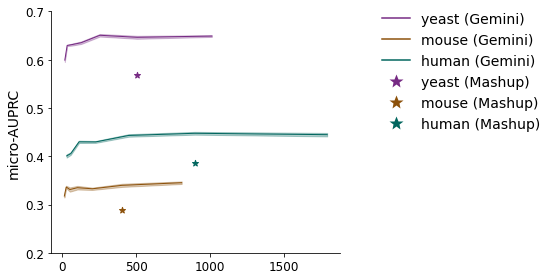

In [7]:
%matplotlib inline

ax = plot_settings.get_wider_axis(1.7)
for org in ['yeast', 'mouse', 'human']:
    plot_utils.line_plot(ax, np.asarray(results_ablate_K[org]['micro_mean']), xlabel='', 
                         ylabel=plot_settings.get_metric_name('micro AUPRC'),
                         xdata=results_ablate_K[org]['input_networks'], max_time=None, invert_axes=False,
                         color=plot_settings.get_species_color(org), linestyle='solid', label_marker=None, 
                         linewidth=1, alpha=0.3, std=np.asarray(results_ablate_K[org]['micro_std'])/np.sqrt(5))
    plot_utils.scatter_plot(ax, [M_total[org]], mashup_comparisons[org]['micro_mean'], xlabel='',
                            ylabel=plot_settings.get_metric_name('micro AUPRC'),
                            color=plot_settings.get_species_color(org), style='*', size=40)

ax.set_ylim(0.2, 0.7)
ax.set_xticks([0, 500, 1000, 1500])

orgs = ['yeast', 'mouse', 'human']
lp = lambda i: plt.plot([],[],color=plot_settings.get_species_color(orgs[i]), ms=30, mec="none",
                        label='{} (Gemini)'.format(orgs[i]), ls="solid")[0]#, marker='solid')[0]
handles = [lp(i) for i in range(len(orgs))]
lp2 = lambda i: plt.plot([],[],color=plot_settings.get_species_color(orgs[i]), ms=15, mec="none",
                        label='{} (Mashup)'.format(orgs[i]), ls="", marker='*')[0]
handles += [lp2(i) for i in range(len(orgs))]
    
plot_utils.format_legend(ax, handles, ['{} (Gemini)'.format(org) for _ in range(3)] +\
                        ['{} (Mashup)'.format(org) for _ in range(3)])
plot_utils.put_legend_outside_plot(ax)
plot_utils.format_ax(ax)
plt.tight_layout()
plt.savefig(fig_dir + 'figure4_c.pdf')

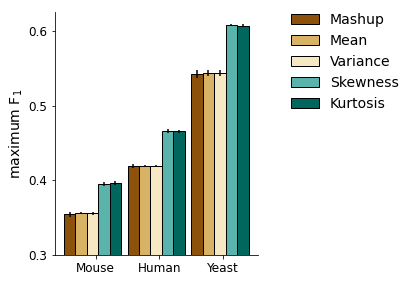

In [8]:
%matplotlib inline
ax = plot_settings.get_wider_axis()

org_ordering = ['mouse', 'human', 'yeast']
means = []
std_errs = []
for org in org_ordering:
    org_means = []
    org_serrs = []
    org_means.extend(mashup_comparisons[org]['f1_mean'])
    org_serrs.extend(mashup_comparisons[org]['f1_std'])
    for moment in range(4):
        org_means.append(results_ablate_moment[org]['f1_mean'][moment])
        org_serrs.append(results_ablate_moment[org]['f1_std'][moment] / np.sqrt(5))
    means.append(np.asarray(org_means))
    std_errs.append(np.asarray(org_serrs))


moment_ordering = ['mashup'] + list(range(1, 5))
plot_utils.grouped_barplot(ax, np.asarray(means), data_labels=[org[0].upper() + org[1:] for org in org_ordering],
                           xlabel='', ylabel=plot_settings.get_metric_name('max f1'), min_val=0.3,
                           nested_color=[plot_settings.get_moment_colors(m) for m in moment_ordering],
                           color_legend=[plot_settings.get_moment_naming(m) for m in moment_ordering],
                           nested_errs=np.asarray(std_errs), tickloc_top=False, rotangle=0)
ax.yaxis.set_ticks([0.3, 0.4, 0.5, 0.6])
plot_utils.format_legend(ax, *ax.get_legend_handles_labels())
plot_utils.put_legend_outside_plot(ax)
plot_utils.format_ax(ax)
plt.tight_layout()
plt.savefig(fig_dir + 'figure4_d.pdf')